In [5]:
#Loading EDA
import pandas
import numpy 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as ticker

In [6]:
#Loading API libraries
from googleapiclient.discovery import build

In [7]:
from dateutil import parser
import isodate

In [8]:
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [9]:
api_key=''

In [10]:
channel_id=['UCge9kgmp38FIjGK4xdJsThw']

In [11]:
api_service_name='youtube'
api_version='v3'

youtube=build(api_service_name,api_version,developerKey=api_key)

## Get channel data

In [12]:
def fetch_channel_data(youtube,channel_id):
    data=[]
    
    request=youtube.channels().list(
    part='snippet,contentDetails,statistics',
    id=','.join(channel_id)
    )
    response=request.execute()
    
    for item in response['items']:
        some_data={'channelName':item['snippet']['title'],
             'subscribers':item['statistics']['subscriberCount'],
             'views':item['statistics']['viewCount'],
             'totalVideos':item['statistics']['videoCount'],
             'playlistId':item['contentDetails']['relatedPlaylists']}
        data.append(some_data)
        
    return(pandas.DataFrame(data))

In [13]:
channel_data=fetch_channel_data(youtube,channel_id)

In [14]:
channel_data

,channelName,subscribers,views,totalVideos,playlistId
0,TechTrek by Keith Galli,4370,35753,5,"{'likes': '', 'uploads': 'UUge9kgmp38FIjGK4xdJ..."


## Get Video Ids

In [15]:
playlist_id='UUge9kgmp38FIjGK4xdJsThw'

In [16]:
def fetch_videoids(youtube,playlist_id):
    videoids=[]
    
    request=youtube.playlistItems().list(
    part='snippet,contentDetails',
    playlistId=playlist_id,
    maxResults=50)
    response=request.execute()
    
    for item in response['items']:
        videoids.append(item['contentDetails']['videoId'])
        
    return videoids

In [17]:
videoids=fetch_videoids(youtube,playlist_id)

In [18]:
videoids

['DnkxaEgen0E', 'l34l-90UF7U', 'OkEoPIOwvhg', 'O93pViG5ITU', 'Lxj4QeQhvlY']

## Get Video Details

In [19]:
def fetch_videodetails(youtube,videoids):
    
    videos_=[]
    
    for i in range(0,len(videoids),50):
        request=youtube.videos().list(
        part='snippet,contentDetails,statistics',
        id=','.join(videoids[i:i+50])
        )
        
        response=request.execute()
        
        for v in response['items']:
            stats={'snippet':['channelTitle','title','description',
                             'tags','publishedAt'],
                  'statistics':['viewCount','likeCount','favouriteCount',
                               'commentCount'],
                  'contentDetails':['duration','definition','caption']}
            
            video_detail={}
            video_detail['video_id']=v['id']
            
            for keep in stats.keys():
                for info in stats[keep]:
                    try:
                        video_detail[info]=v[keep][info]
                    except:
                        video_detail[info]=None
            
            videos_.append(video_detail)
        
    return pandas.DataFrame(videos_)

In [20]:
df=fetch_videodetails(youtube,videoids)

In [21]:
df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,DnkxaEgen0E,TechTrek by Keith Galli,How to Change your Jupyter Notebook Theme (Dar...,In this video we walk through one additional P...,"[Keith Galli, TechTrek, python 3, python3, pro...",2022-06-01T03:37:38Z,5099,86,None,14,PT5M14S,hd,false
1,l34l-90UF7U,TechTrek by Keith Galli,How to work with big data files (5gb+) in Pyth...,"In this video, we quickly go over how to work ...","[keith galli, techtrek, python3, python progra...",2022-05-17T13:01:27Z,5617,387,None,30,PT11M20S,hd,false
2,OkEoPIOwvhg,TechTrek by Keith Galli,Solving an Amazon Data Science Interview Quest...,Today's problem!\nhttps://platform.stratascrat...,"[data science, data analytics, data analysis, ...",2021-03-27T21:52:16Z,15661,469,None,37,PT15M51S,hd,false
3,O93pViG5ITU,TechTrek by Keith Galli,Facebook Data Science Interview Questions with...,Top Search Results (problem #1):\nhttps://plat...,"[keith galli, python, python programming, pand...",2021-03-16T13:00:05Z,7811,296,None,40,PT16M54S,hd,false
4,Lxj4QeQhvlY,TechTrek by Keith Galli,"Hello, world!",Just a short video about the new channel. What...,"[python, programming, data science, python 3, ...",2021-03-15T03:02:58Z,1634,134,None,37,PT6M40S,hd,false


In [22]:
#column list
df.columns

Index(['video_id', 'channelTitle', 'title', 'description', 'tags',
       'publishedAt', 'viewCount', 'likeCount', 'favouriteCount',
       'commentCount', 'duration', 'definition', 'caption'],
      dtype='object')

In [23]:
#checking datatypes
df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [24]:
#Casting 
cols=['viewCount', 'likeCount', 'favouriteCount','commentCount']
df[cols]=df[cols].apply(pandas.to_numeric,axis=1)

In [25]:
#Checking datatypes
df.dtypes

video_id           object
channelTitle       object
title              object
description        object
tags               object
publishedAt        object
viewCount         float64
likeCount         float64
favouriteCount    float64
commentCount      float64
duration           object
definition         object
caption            object
dtype: object

In [26]:
df['publishedAt']=df['publishedAt'].apply(lambda x:parser.parse(x))

In [27]:
df.dtypes

video_id                           object
channelTitle                       object
title                              object
description                        object
tags                               object
publishedAt       datetime64[ns, tzutc()]
viewCount                         float64
likeCount                         float64
favouriteCount                    float64
commentCount                      float64
duration                           object
definition                         object
caption                            object
dtype: object

In [28]:
df['publishDayName']=df['publishedAt'].apply(lambda x:x.strftime('%A'))

In [29]:
df['publishDayName']

0    Wednesday
1      Tuesday
2     Saturday
3      Tuesday
4       Monday
Name: publishDayName, dtype: object

In [30]:
df['durationSecs']=df['duration'].apply(lambda x:isodate.parse_duration(x))

In [31]:
df['durationSecs']

0   0 days 00:05:14
1   0 days 00:11:20
2   0 days 00:15:51
3   0 days 00:16:54
4   0 days 00:06:40
Name: durationSecs, dtype: timedelta64[ns]

In [32]:
df['durationSecs']=df['durationSecs'].astype('timedelta64[s]')

In [33]:
df[['durationSecs','duration']]

,durationSecs,duration
0,314.0,PT5M14S
1,680.0,PT11M20S
2,951.0,PT15M51S
3,1014.0,PT16M54S
4,400.0,PT6M40S


In [34]:
#counting tags
df['tagCount']=df['tags'].apply(lambda x:0 if x is None else len(x))

In [35]:
df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,publishDayName,durationSecs,tagCount
0,DnkxaEgen0E,TechTrek by Keith Galli,How to Change your Jupyter Notebook Theme (Dar...,In this video we walk through one additional P...,"[Keith Galli, TechTrek, python 3, python3, pro...",2022-06-01 03:37:38+00:00,5099.0,86.0,NaN,14.0,PT5M14S,hd,false,Wednesday,314.0,25
1,l34l-90UF7U,TechTrek by Keith Galli,How to work with big data files (5gb+) in Pyth...,"In this video, we quickly go over how to work ...","[keith galli, techtrek, python3, python progra...",2022-05-17 13:01:27+00:00,5617.0,387.0,NaN,30.0,PT11M20S,hd,false,Tuesday,680.0,26
2,OkEoPIOwvhg,TechTrek by Keith Galli,Solving an Amazon Data Science Interview Quest...,Today's problem!\nhttps://platform.stratascrat...,"[data science, data analytics, data analysis, ...",2021-03-27 21:52:16+00:00,15661.0,469.0,NaN,37.0,PT15M51S,hd,false,Saturday,951.0,20
3,O93pViG5ITU,TechTrek by Keith Galli,Facebook Data Science Interview Questions with...,Top Search Results (problem #1):\nhttps://plat...,"[keith galli, python, python programming, pand...",2021-03-16 13:00:05+00:00,7811.0,296.0,NaN,40.0,PT16M54S,hd,false,Tuesday,1014.0,29
4,Lxj4QeQhvlY,TechTrek by Keith Galli,"Hello, world!",Just a short video about the new channel. What...,"[python, programming, data science, python 3, ...",2021-03-15 03:02:58+00:00,1634.0,134.0,NaN,37.0,PT6M40S,hd,false,Monday,400.0,8


## Exploratory Data Analysis

## Popular Videos List

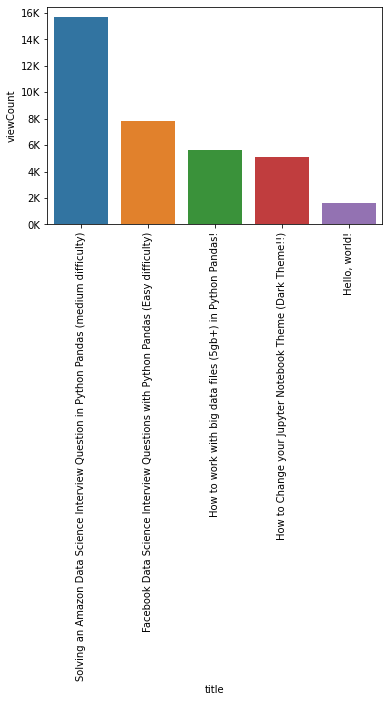

In [36]:
bar=sns.barplot(x='title',y='viewCount',data=df.sort_values('viewCount',ascending=False)[0:9])
plot=bar.set_xticklabels(bar.get_xticklabels(),rotation=90)
bar.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,pos:'{:,.0f}'.format(x/1000)+'K'))

## Least Popular Video Lists

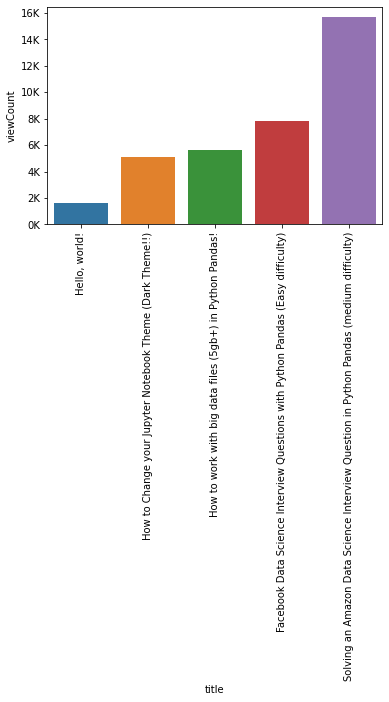

In [37]:
bar=sns.barplot(x='title',y='viewCount',data=df.sort_values('viewCount',ascending=True)[0:9])
plot=bar.set_xticklabels(bar.get_xticklabels(),rotation=90)
bar.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,pos:'{:,.0f}'.format(x/1000)+'K'))

## ViewCount distribution

/Users/sahjarakaur/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='channelTitle', ylabel='viewCount'>

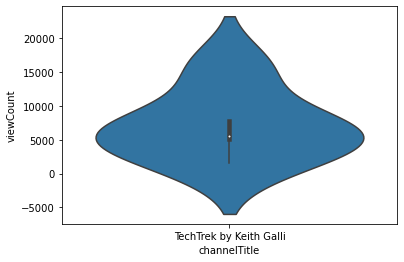

In [38]:
sns.violinplot(df['channelTitle'],df['viewCount'])

## Number of ViewCount with Likes and Comments

<AxesSubplot:xlabel='likeCount', ylabel='viewCount'>

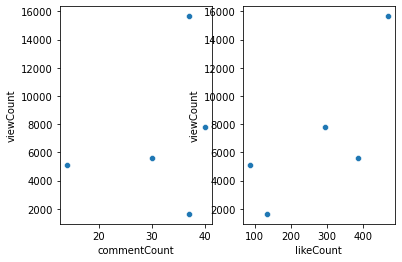

In [39]:
fig,ax=plt.subplots(1,2)
sns.scatterplot(data=df,x='commentCount',y='viewCount',ax=ax[0])
sns.scatterplot(data=df,x='likeCount',y='viewCount',ax=ax[1])

## Duration of Video

<AxesSubplot:xlabel='durationSecs', ylabel='Count'>

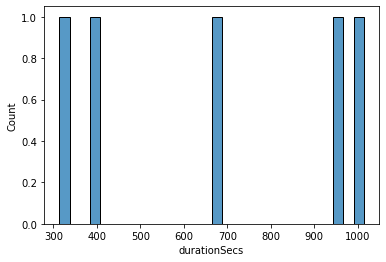

In [40]:
sns.histplot(data=df,x='durationSecs',bins=30)

## Video Titles

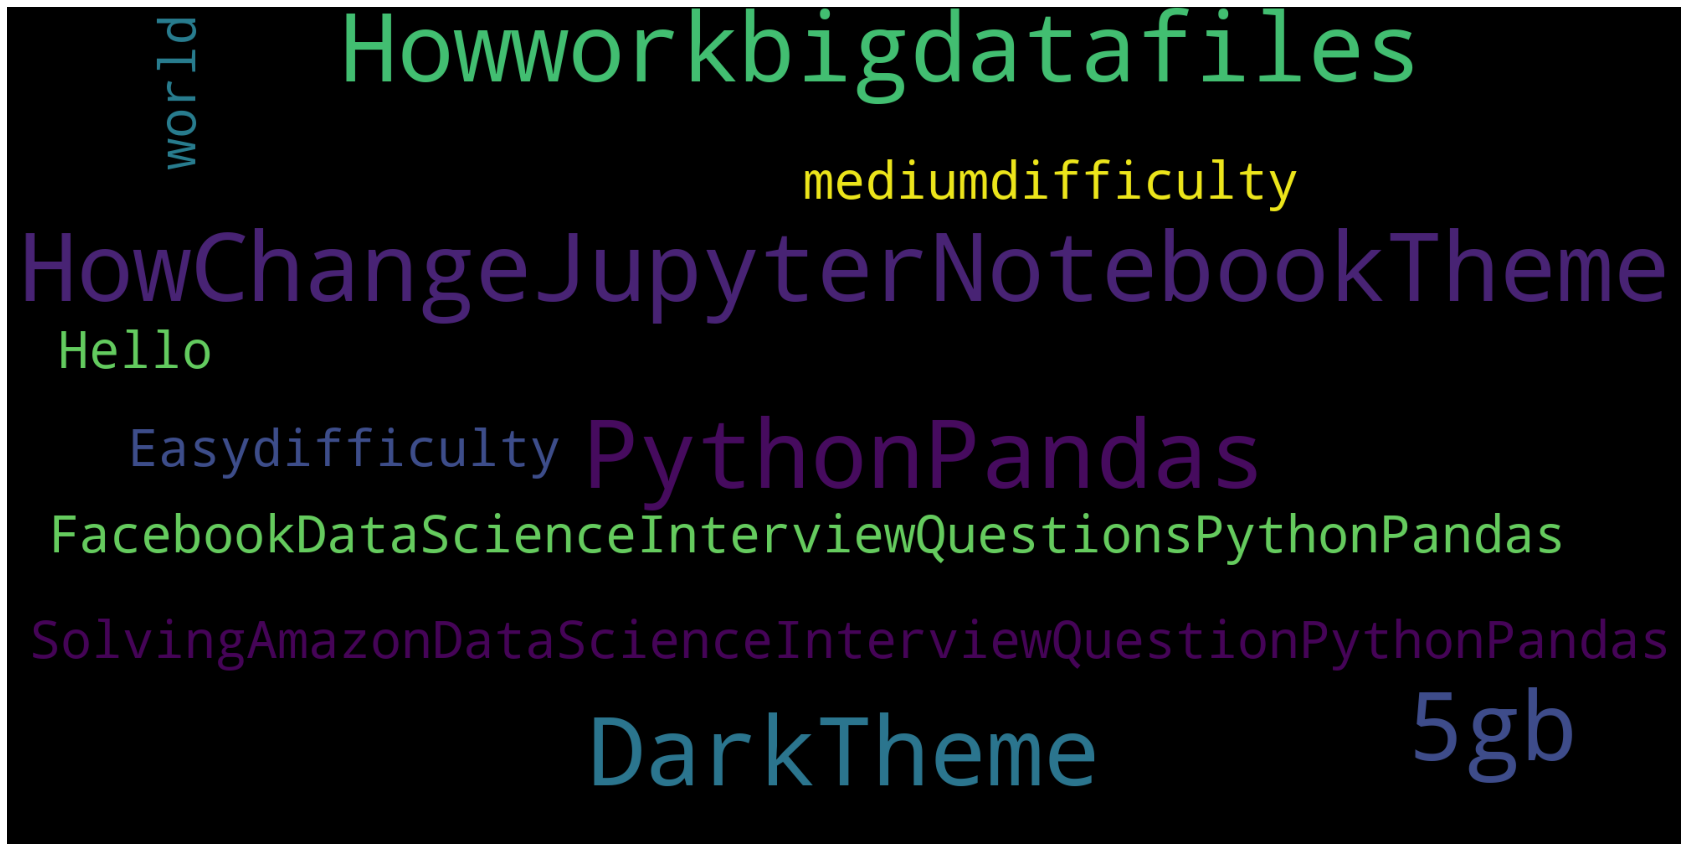

In [41]:
stop_words=set(stopwords.words('english'))
df['title_stopwords']=df['title'].apply(lambda x:[item for item in str(x).split() if item not in stop_words])

all_words=list([a for z in df['title_stopwords'].tolist() for a in z])
all_words_str=''.join(all_words)

def plot(word):
    plt.figure(figsize=(30,20))
    plt.imshow(word)
    plt.axis('off')

word=WordCloud(width=2000,height=1000,random_state=1,background_color='black',
              colormap='viridis',collocations=False).generate(all_words_str)
plot(word)

In [42]:
days=pandas.DataFrame(df['publishDayName'].value_counts())

In [43]:
days

,publishDayName
Tuesday,2
Wednesday,1
Saturday,1
Monday,1


In [44]:
weekDays=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
days=days.reindex(weekDays)

In [45]:
days

,publishDayName
Monday,1.0
Tuesday,2.0
Wednesday,1.0
Thursday,NaN
Friday,NaN
Saturday,1.0
Sunday,NaN


## Check Schedule

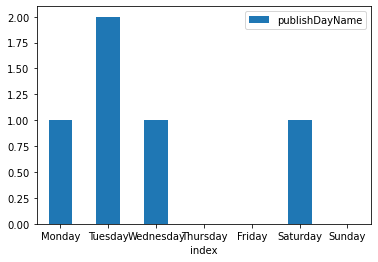

In [46]:
bar=days.reset_index().plot.bar(x='index',y='publishDayName',rot=0)

In [47]:
df.to_csv('techtrek.csv',index=False)